# Bitcoin Price Prediction

**Name:** Jose Ayala<br>
**Class:** CAP5619 - Artificial Intelligence for FinTech<br>
**Assignment:** Explaining Model Decisions for Bitcoin Price Prediction with Chainlets<br>
**Date:** April 3, 2025  

# Import Libraries

Imports necessary Python libraries for data manipulation, machine learning, visualization, and warning management.

**Code Functionality:**

* `pandas`: Imports the pandas library as `pd` for data manipulation and analysis, particularly for working with DataFrames.
* `sklearn.linear_model.Ridge`: Imports the Ridge regression model from scikit-learn for linear regression with L2 regularization.
* `sklearn.metrics.mean_squared_error`: Imports the mean squared error function from scikit-learn for model evaluation.
* `numpy`: Imports the NumPy library as `np` for numerical computations.
* `matplotlib.pyplot`: Imports the matplotlib.pyplot module as `plt` for creating visualizations.
* `shap`: Imports the SHAP library for explainable AI and feature importance analysis.
* `warnings`: Imports the warnings module for managing warnings.
* `warnings.simplefilter('ignore')`: Ignores all warning messages, which is generally not recommended for production code but can be useful for cleaner output during development.

**Purpose:**

This cell imports all the required libraries at the beginning of the notebook, making them available for use in subsequent cells.

In [1]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings
warnings.simplefilter('ignore')

# Load the Data

Loads the required datasets from their respective files into memory. The files are expected to exist in the same directory as the script.

**Code Functionality:**

* Reads three CSV files: `pricedBitcoin2009-2018.csv`, `AmoChainletsInTime.txt`, and `OccChainletsInTime.txt`.
* Uses `pandas.read_csv()` to load the data into pandas DataFrames.
* The `AmoChainletsInTime.txt` and `OccChanletsInTime.txt` file uses tab (`\t`) delimiters.
* Returns the three DataFrames: `price_data`, `amo_data`, and `occ_data`.

**Purpose:**

This function initializes the data required for further analysis by loading it from external files into a usable format.

In [2]:
def load_data():
    """Loads the price and chainlet data."""
    price_data = pd.read_csv("pricedBitcoin2009-2018.csv")
    amo_data = pd.read_csv("AmoChainletsInTime.txt", sep="\t")
    occ_data = pd.read_csv("OccChainletsInTime.txt", sep="\t")
    return price_data, amo_data, occ_data

# Prepare Date Columns

Converts the 'date' column in the price data DataFrame to datetime objects and extracts the year and day of year into separate columns.

**Code Functionality:**

* Takes a pandas DataFrame `price_data` as input.
* Uses `pd.to_datetime()` to convert the 'date' column to datetime objects.
* Extracts the year from the datetime objects and creates a new 'year' column.
* Extracts the day of year from the datetime objects and creates a new 'day' column.
* Returns the modified `price_data` DataFrame.

**Purpose:**

This function preprocesses the date information in the price data, transforming it into a format suitable for time-based analysis and merging with other datasets.

In [3]:
def prepare_date_columns(price_data):
    """Converts 'date' to datetime and extracts year and day."""
    price_data['date'] = pd.to_datetime(price_data['date'])
    price_data['year'] = price_data['date'].dt.year
    price_data['day'] = price_data['date'].dt.dayofyear
    return price_data

# Merge Chainlet Data

Merges the amo and occ chainlet data with the price data based on the 'year' and 'day' columns.

**Code Functionality:**

* Takes three pandas DataFrames as input: `price_data`, `amo_data`, and `occ_data`.
* Merges `amo_data` and `occ_data` DataFrames using `pd.merge()` on the 'year' and 'day' columns.
* Applies suffixes `_amo` and `_occ` to differentiate columns from the two DataFrames.
* Merges the resulting DataFrame with `price_data` using `pd.merge()` on the 'year' and 'day' columns, performing a left merge to preserve all rows from `price_data`.
* Returns the final merged DataFrame.

**Purpose:**

This function combines the price data with the chainlet data, creating a single DataFrame that includes all relevant information for the analysis.

In [4]:
def merge_chainlet_data(price_data, amo_data, occ_data):
    """Merges amo and occ chainlet data with price data."""
    merged_amo_occ = pd.merge(amo_data, occ_data, on=['year', 'day'], suffixes=('_amo', '_occ'))
    final_merged_data = pd.merge(price_data, merged_amo_occ, on=['year', 'day'], how='left')
    return final_merged_data

# Create Lagged Price Feature

Creates a lagged price feature in the DataFrame by shifting the 'price' column by one row and then removes any rows with missing values.

**Code Functionality:**

* Takes a pandas DataFrame `df` as input.
* Creates a new column named 'price_lag1' by shifting the 'price' column down by one row using the `shift(1)` method.
* Removes any rows containing missing values (NaN) that result from the shift operation using `dropna()`.
* Returns the modified DataFrame.

**Purpose:**

This function adds a lagged price feature, which is often used in time series analysis to capture the previous day's price as a predictor. It also ensures that the DataFrame is clean and free of missing values.

In [5]:
def create_lagged_price(df):
    """Creates a lagged price feature."""
    df['price_lag1'] = df['price'].shift(1)
    return df.dropna()

# Filter Data by Year

Filters the DataFrame to include only rows within a specified year range.

**Code Functionality:**

* Takes a pandas DataFrame `df`, a `start_year`, and an `end_year` as input.
* Filters the DataFrame to include rows where the year from the 'date' column is greater than or equal to `start_year` and less than or equal to `end_year`.
* Returns the filtered DataFrame.

**Purpose:**

This function allows you to select a subset of the data for analysis, focusing on a specific time period.

In [6]:
def filter_data_by_year(df, start_year, end_year):
    """Filters the DataFrame by year."""
    return df[(df['date'].dt.year >= start_year) & (df['date'].dt.year <= end_year)]

# Select Chainlet Columns

Selects specific chainlet columns ('1:1_amo' and '1:1_occ') and drops all other chainlet-related and unnecessary columns from the DataFrame.

**Code Functionality:**

* Takes a pandas DataFrame `df` as input.
* Identifies all columns containing '_amo' and '_occ' in their names.
* Defines a list `selected_chainlets` containing the columns '1:1_amo' and '1:1_occ'.
* Creates a list `columns_to_drop` that initially includes 'year', 'day', 'totaltx', 'totaltx_amo', and 'totaltx_occ'.
* Extends `columns_to_drop` with all other columns containing '_amo' or '_occ' that are not in `selected_chainlets`.
* Drops the columns listed in `columns_to_drop` from the DataFrame using `df.drop()`.
* Returns the modified DataFrame with only the selected chainlet columns and other necessary columns.

**Purpose:**

This function filters the DataFrame to include only the relevant chainlet features needed for the analysis, simplifying the data and reducing dimensionality.

In [7]:
def select_chainlet_columns(df):
    """Selects the '1:1_amo' and '1:1_occ' chainlet columns."""
    amo_cols = [col for col in df.columns if '_amo' in col]
    occ_cols = [col for col in df.columns if '_occ' in col]
    selected_chainlets = ['1:1_amo', '1:1_occ']
    columns_to_drop = ['year', 'day', 'totaltx', 'totaltx_amo', 'totaltx_occ']
    columns_to_drop.extend([col for col in df.columns if ('_amo' in col or '_occ' in col) and col not in selected_chainlets])
    return df.drop(columns=columns_to_drop)

# Check Missing Values

Checks for missing values in the DataFrame and prints the count of missing values for each column.

**Code Functionality:**

* Takes a pandas DataFrame `df` as input.
* Calculates the sum of missing values (NaN) for each column using `df.isnull().sum()`.
* Prints the resulting Series, displaying the column names and their corresponding missing value counts.

**Purpose:**

This function performs a data quality check to identify any missing values in the DataFrame, allowing for appropriate handling of missing data in subsequent analysis.

In [8]:
def check_missing_values(df):
    """Checks and prints missing values."""
    missing_values = df.isnull().sum()
    print("Missing Values per Column:")
    print(missing_values)

# Check Data Types

Checks and prints the data types of each column in the DataFrame.

**Code Functionality:**

* Takes a pandas DataFrame `df` as input.
* Prints a header "Data Types of Columns:".
* Prints the data types of each column using `df.dtypes`.

**Purpose:**

This function provides a quick overview of the data types present in the DataFrame, ensuring that the data is in the expected format for further processing and analysis.

In [9]:
def check_data_types(df):
    """Checks and prints data types."""
    print("\nData Types of Columns:")
    print(df.dtypes)

# Split Data into Training and Testing Sets

Splits the DataFrame into training and testing sets based on the 'date' column, specifically for the year 2017.

**Code Functionality:**

* Takes a pandas DataFrame `df` as input.
* Creates a `train_data` DataFrame containing rows where the year is 2017 and the month is less than 12 (January 1, 2017 to November 30, 2017).
* Creates a `test_data` DataFrame containing rows where the year is 2017 and the month is 12 (December 1, 2017 to December 31, 2017).
* Returns the `train_data` and `test_data` DataFrames.

**Purpose:**

This function prepares the data for model training and evaluation by dividing it into distinct training and testing sets, using the specified time-based criteria.

In [10]:
def split_data(df):
    """Splits the data into training and testing sets."""
    train_data = df[(df['date'].dt.year == 2017) & (df['date'].dt.month < 12)] # 2017-01-01 to 2017-11-30
    test_data = df[(df['date'].dt.year == 2017) & (df['date'].dt.month == 12)] # 2017-12-01 to 2017-12-31
    return train_data, test_data

# Train Ridge Regression Model

Trains a Ridge Regression model using the provided training data.

**Code Functionality:**

* Takes the training features `X_train`, the target variable `y_train`, and an optional `alpha` parameter (defaulting to 1.0) as input.
* Creates a `Ridge` regression model instance from scikit-learn, using the provided `alpha` for regularization.
* Fits the model to the training data using the `fit()` method.
* Returns the trained Ridge Regression model.

**Purpose:**

This function trains a Ridge Regression model, which is a linear regression model with L2 regularization, to predict the target variable based on the training features. The `alpha` parameter controls the strength of the regularization.

In [11]:
def train_ridge_regression(X_train, y_train, alpha=1.0):
    """Trains a Ridge Regression model."""
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    return model

# Make Predictions

Generates predictions using the trained model on the provided test data.

**Code Functionality:**

* Takes a trained model (`model`) and the test features (`X_test`) as input.
* Uses the `predict()` method of the trained model to generate predictions for the test data.
* Returns the predicted values (`y_pred`).

**Purpose:**

This function applies the trained model to the test data to generate predictions, which are then used to evaluate the model's performance.

In [12]:
def make_predictions(model, X_test):
    """Makes predictions using the trained model."""
    y_pred = model.predict(X_test)
    return y_pred

# Calculate RMSE (Root Mean Squared Error)

Calculates the Root Mean Squared Error (RMSE) between the actual and predicted values.

**Code Functionality:**

* Takes the actual test values (`y_test`) and the predicted values (`y_pred`) as input.
* Uses the `mean_squared_error()` function from scikit-learn to calculate the mean squared error between the actual and predicted values.
* Calculates the square root of the mean squared error using `np.sqrt()` to obtain the RMSE.
* Returns the calculated RMSE.

**Purpose:**

This function evaluates the performance of the regression model by calculating the RMSE, which measures the average magnitude of the errors between the predicted and actual values.

In [13]:
def calculate_rmse(y_test, y_pred):
    """Calculates the RMSE."""
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Create Predictions DataFrame

Creates a pandas DataFrame containing the predicted prices and their corresponding dates from the test data.

**Code Functionality:**

* Takes the `test_data` DataFrame and the predicted prices `y_pred` as input.
* Creates a new pandas DataFrame `predictions_df`.
* Adds a 'date' column to `predictions_df` from the 'date' column of `test_data`.
* Adds a 'predicted_price' column to `predictions_df` containing the predicted prices `y_pred`.
* Returns the `predictions_df` DataFrame.

**Purpose:**

This function organizes the predicted prices and their associated dates into a DataFrame, making it easier to analyze and visualize the predictions in a time-series context.

In [14]:
def create_predictions_dataframe(test_data, y_pred):
    """Creates a DataFrame for predictions with dates."""
    predictions_df = pd.DataFrame({'date': test_data['date'], 'predicted_price': y_pred})
    return predictions_df

# Output Predictions to CSV

Saves the predictions DataFrame to a CSV file.

**Code Functionality:**

* Takes the `predictions_df` DataFrame and an optional `filename` (defaulting to "price_predictions.csv") as input.
* Uses the `to_csv()` method of the DataFrame to save the data to a CSV file, with `index=False` to prevent writing the DataFrame index to the file.
* Prints a message to the console indicating that the predictions have been saved to the specified filename.

**Purpose:**

This function allows you to save the model predictions to a CSV file for further analysis, reporting, or sharing.

In [15]:
def output_predictions_to_csv(predictions_df, filename="price_predictions.csv"):
    """Outputs the predictions to a CSV file."""
    predictions_df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}\n")

# Plot Actual vs. Predicted Bitcoin Prices

Plots the actual Bitcoin prices from the test data against the predicted prices from the model.

**Code Functionality:**

* Takes the `test_data` DataFrame and the `predictions_df` DataFrame as input.
* Creates a new figure with a size of 12x6 inches using `plt.figure()`.
* Plots the actual Bitcoin prices from the 'price' column of `test_data` against the 'date' column, labeling it "Actual Price" and using circle markers.
* Plots the predicted Bitcoin prices from the 'predicted_price' column of `predictions_df` against the 'date' column, labeling it "Predicted Price" and using cross markers.
* Sets the plot title to "Actual vs. Predicted Bitcoin Prices (December 2017)".
* Sets the x-axis label to "Date".
* Sets the y-axis label to "Bitcoin Price (USD)".
* Adds a legend to the plot.
* Adds a grid to the plot.
* Rotates the x-axis tick labels by 45 degrees for better readability.
* Adjusts the plot layout to prevent clipping of labels.
* Displays the plot using `plt.show()`.

**Purpose:**

This function visualizes the model's performance by comparing the actual and predicted Bitcoin prices over time, allowing for a visual assessment of the model's accuracy.

In [16]:
def plot_actual_vs_predicted(test_data, predictions_df):
    """Plots the actual and predicted Bitcoin prices."""
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['date'], test_data['price'], label='Actual Price', marker='o')
    plt.plot(predictions_df['date'], predictions_df['predicted_price'], label='Predicted Price', marker='x')
    plt.title('Actual vs. Predicted Bitcoin Prices (December 2017)')
    plt.xlabel('Date')
    plt.ylabel('Bitcoin Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ridge Regression Execution

Executes the main pipeline for the Ridge Regression analysis, including data loading, preprocessing, model training, prediction, and evaluation.

**Code Functionality:**

1.  **Data Loading and Preprocessing:**
    * Loads the price and chainlet data using `load_data()`.
    * Prepares the date columns using `prepare_date_columns()`.
    * Merges the chainlet data with the price data using `merge_chainlet_data()`.
    * Creates a lagged price feature using `create_lagged_price()`.
    * Filters the data for the year 2017 using `filter_data_by_year()`.
    * Selects relevant chainlet columns using `select_chainlet_columns()`.
    * (Optional debugging: checks for missing values and data types, commented out).

2.  **Data Splitting:**
    * Splits the data into training and testing sets using `split_data()`.
    * Separates the features (`X_train`, `X_test`) and target variable (`y_train`, `y_test`).

3.  **Model Training and Prediction:**
    * Trains a Ridge Regression model using `train_ridge_regression()`.
    * Makes predictions on the test data using `make_predictions()`.
    * Calculates the RMSE using `calculate_rmse()`.
    * Creates a DataFrame for the predictions with dates using `create_predictions_dataframe()`.

4.  **Output and Visualization:**
    * Prints the RMSE to the console.
    * Saves the predictions to a CSV file using `output_predictions_to_csv()`.
    * Plots the actual vs. predicted prices using `plot_actual_vs_predicted()`.
    * Returns the trained model, training and testing data, and predictions DataFrame.

**Purpose:**

This function encapsulates the entire Ridge Regression analysis, from data preparation to model evaluation and output, providing a complete workflow for predicting Bitcoin prices.

In [17]:
def ridge_regression():
    """Main execution function."""
    price_data, amo_data, occ_data = load_data()
    price_data = prepare_date_columns(price_data)
    final_merged_data = merge_chainlet_data(price_data, amo_data, occ_data)
    processed_data = create_lagged_price(final_merged_data)
    processed_data = filter_data_by_year(processed_data, start_year=2017, end_year=2017)
    processed_data = select_chainlet_columns(processed_data)

    # used for debugging
    # check_missing_values(processed_data)
    # check_data_types(processed_data)

    train_data, test_data = split_data(processed_data)

    X_train = train_data.drop(['price', 'date'], axis=1)
    y_train = train_data['price']
    X_test = test_data.drop(['price', 'date'], axis=1)
    y_test = test_data['price']

    # Train Ridge Regression model
    ridge_model = train_ridge_regression(X_train, y_train, alpha=1.0) # You can adjust alpha
    y_pred_ridge = make_predictions(ridge_model, X_test)
    rmse_ridge = calculate_rmse(y_test, y_pred_ridge)
    predictions_df_ridge = create_predictions_dataframe(test_data, y_pred_ridge)

    print(f"\nRMSE with Ridge Regression: {rmse_ridge}")
    output_predictions_to_csv(predictions_df_ridge, "price_predictions_ridge.csv")
    plot_actual_vs_predicted(test_data, predictions_df_ridge)

    return ridge_model, X_train, X_test, test_data, predictions_df_ridge, y_test

# SHAP Summary Plot Generation

Generates and displays a SHAP (SHapley Additive exPlanations) summary plot to visualize feature importance.

**Code Functionality:**

* Takes a trained model (`model`), training features (`X_train`), and test features (`X_test`) as input.
* Creates a SHAP `Explainer` object using the trained model and training features.
* Calculates SHAP values for the test features using the `explainer`.
* Generates a SHAP summary plot using `shap.summary_plot()`, displaying the feature importance across all predictions.
* Shows the generated plot using `plt.show()`.
* Closes the plot using `plt.close()`, to prevent conflicts if more plots are generated later.

**Purpose:**

This function provides a visual representation of feature importance, showing how each feature contributes to the model's predictions. The summary plot helps understand which features are most influential in determining the predicted Bitcoin prices.

In [18]:
def shap_summary(model, X_train, X_test):
    """Generates and displays the SHAP summary plot."""
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())
    plt.show()
    plt.close()

# Individual Prediction Explanations (SHAP Decision Plots)

Provides detailed explanations for individual predictions from the Ridge Regression model using SHAP decision plots.

**Code Functionality:**

* Takes the trained model (`model`), training features (`X_train`), test features (`X_test`), test data (`test_data`), predictions DataFrame (`predictions_df`), and actual test values (`y_test`) as input.
* Creates a SHAP `Explainer` object using the trained model and training features.
* Calculates SHAP values for the test features.
* Iterates through the first 5 test samples:
    * Prints a separator line for clarity.
    * Prints a header indicating the date of the prediction being explained.
    * Generates and displays a SHAP decision plot using `shap.decision_plot()`, showing the progression of the model's prediction as features are added.
    * Closes the plot to prevent conflicts with subsequent plots.
    * Prints the predicted price, actual price, and their difference.
    * Prints the influential features for the prediction, along with their SHAP values.

**Purpose:**

This function provides insight into the model's decision-making process for individual predictions. The decision plots help visualize how the model's prediction evolves as features are considered, showing the impact of each feature on the final prediction.

In [19]:
def prediction_explanation(model, X_train, X_test, test_data, predictions_df, y_test):
    """\nExplains the predictions for the first 5 test samples using decision plots."""
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    for i in range(5):
        print("\n-----------------------------------------------------------------------------------------------")
        print(f"\nExplanation for prediction on {test_data['date'].iloc[i]}:\n")
        shap.decision_plot(explainer.expected_value, shap_values.values[i], X_test.iloc[i], show=False)
        plt.show()
        plt.close()
        print(f"The predicted price was: {predictions_df['predicted_price'].iloc[i]:.2f}")
        print(f"The actual price was: {y_test.iloc[i]:.2f}")
        print(f"The difference was: {predictions_df['predicted_price'].iloc[i]-y_test.iloc[i]:.2f}")
        print("Influential features:")
        for name, value in zip(X_test.columns, shap_values.values[i]):
            print(f"  {name}: {value:.2f}")

# Execute Ridge Regression Analysis

Executes the main Ridge Regression analysis pipeline and assigns the returned values to variables.

**Code Functionality:**

* Calls the `ridge_regression()` function, which performs the entire Ridge Regression analysis, including data loading, preprocessing, model training, prediction, and evaluation.
* Assigns the returned values from `ridge_regression()` to the following variables:
    * `ridge_model`: The trained Ridge Regression model.
    * `X_train`: The training features DataFrame.
    * `X_test`: The test features DataFrame.
    * `test_data`: The test data DataFrame.
    * `predictions_df_ridge`: The DataFrame containing the predicted prices and dates.
    * `y_test`: The actual test prices.

**Purpose:**

This cell executes the core Ridge Regression analysis and makes the results available for further processing, visualization, and interpretation in subsequent cells.


RMSE with Ridge Regression: 1110.0526326376378
Predictions saved to price_predictions_ridge.csv



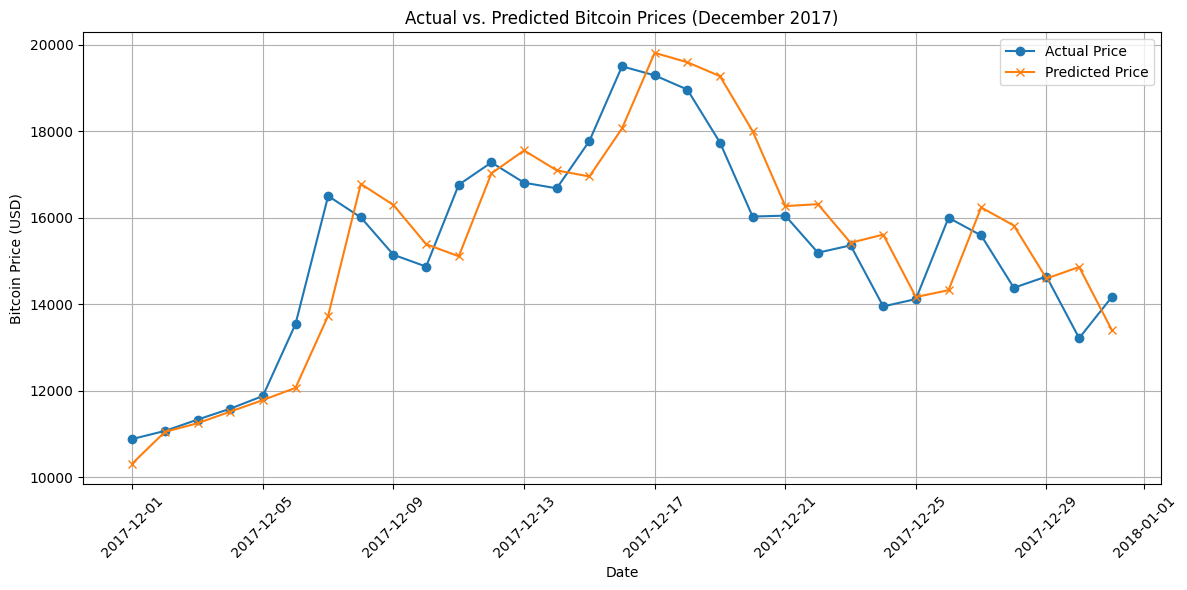

In [20]:
ridge_model, X_train, X_test, test_data, predictions_df_ridge, y_test = ridge_regression()

## SHAP Summary Plot Explanation

The following summary plot shows the overall feature importance across all predictions in the test set.

* Each point on the plot represents a SHAP value for a feature and an instance.
* The x-axis represents the SHAP value, which indicates how much a feature contributed to the prediction.
* The color of the points represents the feature value (red indicates high, blue indicates low).
* Features are ordered by importance, with the most important feature at the top.

### Interpretation of Feature Impact:

* Positive SHAP values indicate that the feature increased the predicted price.
* Negative SHAP values indicate that the feature decreased the predicted price.
* Red points indicate that higher values of the feature had a greater impact on the predicted price.
* Blue points indicate that lower values of the feature had a greater impact on the predicted price.

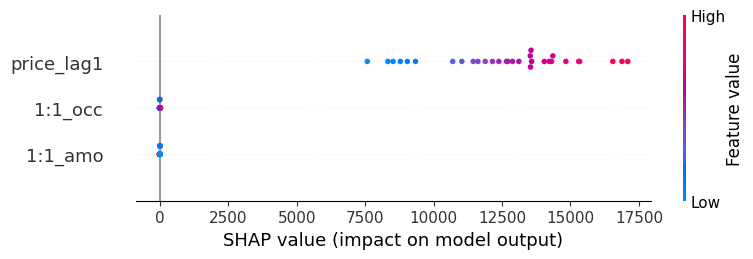

In [21]:
shap_summary(ridge_model, X_train, X_test)

# Generate and Display Prediction Explanations

Executes the `prediction_explanation` function to generate and display SHAP decision plots for the first 5 test samples, providing insights into the model's prediction process.

**Code Functionality:**

* Calls the `prediction_explanation` function with the trained Ridge Regression model (`ridge_model`), training features (`X_train`), test features (`X_test`), test data (`test_data`), predictions DataFrame (`predictions_df_ridge`), and actual test values (`y_test`).
* The `prediction_explanation` function:
    * Generates SHAP decision plots for the first 5 test samples.
    * Prints the predicted price, actual price, and their difference for each sample.
    * Prints the influential features and their SHAP values for each sample.

**Purpose:**

This cell executes the prediction explanation process, visualizing and describing the model's behavior for specific predictions, aiding in model interpretability and understanding.


-----------------------------------------------------------------------------------------------

Explanation for prediction on 2017-12-01 00:00:00:



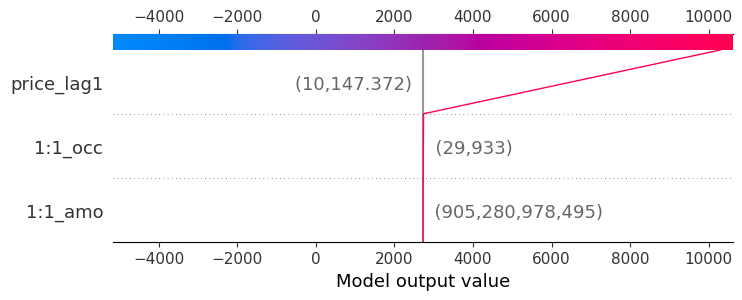

The predicted price was: 10317.24
The actual price was: 10883.91
The difference was: -566.67
Influential features:
  1:1_amo: 5.44
  1:1_occ: 8.57
  price_lag1: 7577.30

-----------------------------------------------------------------------------------------------

Explanation for prediction on 2017-12-02 00:00:00:



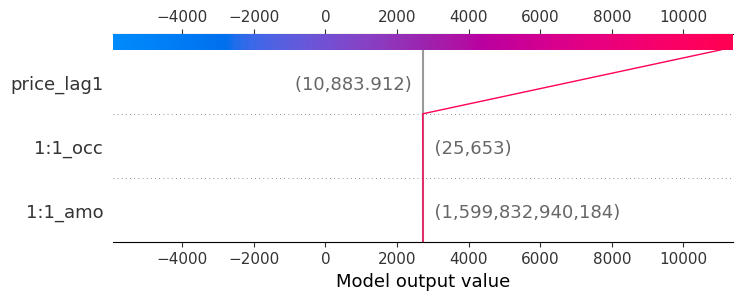

The predicted price was: 11049.17
The actual price was: 11071.37
The difference was: -22.20
Influential features:
  1:1_amo: -0.47
  1:1_occ: -3.11
  price_lag1: 8326.82

-----------------------------------------------------------------------------------------------

Explanation for prediction on 2017-12-03 00:00:00:



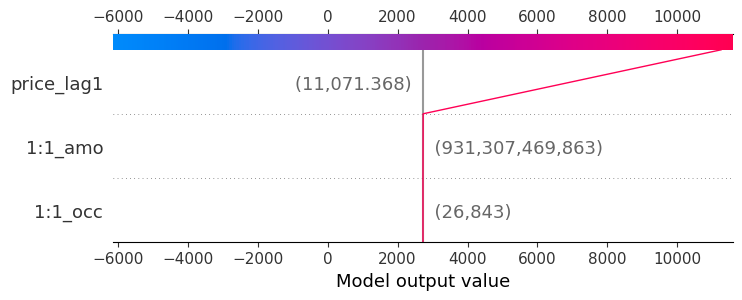

The predicted price was: 11248.87
The actual price was: 11332.62
The difference was: -83.76
Influential features:
  1:1_amo: 5.22
  1:1_occ: 0.14
  price_lag1: 8517.58

-----------------------------------------------------------------------------------------------

Explanation for prediction on 2017-12-04 00:00:00:



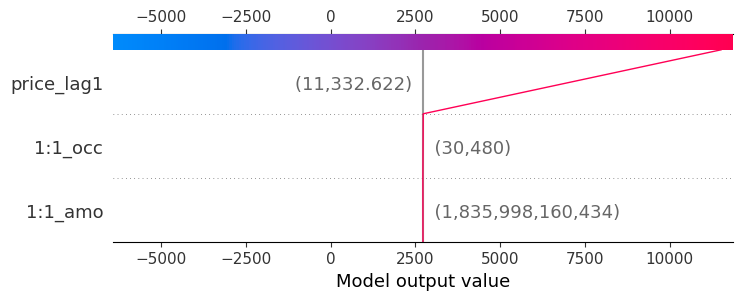

The predicted price was: 11516.94
The actual price was: 11584.83
The difference was: -67.89
Influential features:
  1:1_amo: -2.48
  1:1_occ: 10.06
  price_lag1: 8783.44

-----------------------------------------------------------------------------------------------

Explanation for prediction on 2017-12-05 00:00:00:



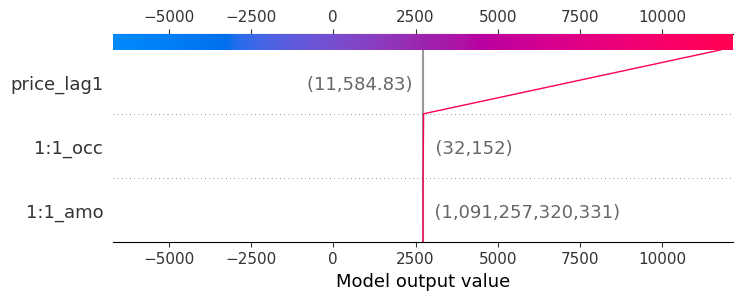

The predicted price was: 11784.50
The actual price was: 11878.43
The difference was: -93.93
Influential features:
  1:1_amo: 3.86
  1:1_occ: 14.62
  price_lag1: 9040.09


In [22]:
prediction_explanation(ridge_model, X_train, X_test, test_data, predictions_df_ridge, y_test)